# Fisheries competition and other CNN tricks

In this notebook we will classify species of fish. We will be using data from the [Kaggle competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/). 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
from collections import Counter

In [2]:
import cv2
import matplotlib.pyplot as plt 

## Data

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. (If you don't provide a path you will find your data in /home/user/.kaggle/competitit )<br/>
`kaggle competitions download -c the-nature-conservancy-fisheries-monitoring -p /data2/yinterian/fisheries` <br/>

In [4]:
PATH = Path("/data2/yinterian/fisheries")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/fisheries/test_stg1.zip'),
 PosixPath('/data2/yinterian/fisheries/__MACOSX'),
 PosixPath('/data2/yinterian/fisheries/sample_submission_stg2.csv.zip'),
 PosixPath('/data2/yinterian/fisheries/test_stg2.7z'),
 PosixPath('/data2/yinterian/fisheries/sample_submission_stg1.csv.zip'),
 PosixPath('/data2/yinterian/fisheries/train.zip'),
 PosixPath('/data2/yinterian/fisheries/train')]

In [5]:
list((PATH/"train").iterdir())

[PosixPath('/data2/yinterian/fisheries/train/DOL'),
 PosixPath('/data2/yinterian/fisheries/train/NoF'),
 PosixPath('/data2/yinterian/fisheries/train/LAG'),
 PosixPath('/data2/yinterian/fisheries/train/SHARK'),
 PosixPath('/data2/yinterian/fisheries/train/OTHER'),
 PosixPath('/data2/yinterian/fisheries/train/.DS_Store'),
 PosixPath('/data2/yinterian/fisheries/train/BET'),
 PosixPath('/data2/yinterian/fisheries/train/YFT'),
 PosixPath('/data2/yinterian/fisheries/train/ALB')]

In [6]:
list((PATH/"train"/"ALB").iterdir())[:5]

[PosixPath('/data2/yinterian/fisheries/train/ALB/img_02140.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/ALB/img_04320.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/ALB/img_06727.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/ALB/img_06086.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/ALB/img_04377.jpg')]

In [7]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

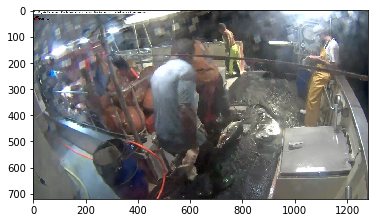

In [8]:
path = PATH/"train/ALB/img_02140.jpg"
im = read_image(path)
plt.imshow(im)

In [9]:
im = cv2.imread(str(path))  #.astype(np.float32)/255
im.shape

(720, 1280, 3)

In [10]:
# let's look at the typical size of these images
files = list((PATH/"train/ALB/").iterdir()) + list((PATH/"train/SHARK/").iterdir())
dims = [read_image(str(p)).shape for p in files]
counts = Counter(dims)
counts

Counter({(720, 1280, 3): 1163,
         (854, 1518, 3): 6,
         (670, 1192, 3): 164,
         (750, 1280, 3): 330,
         (974, 1280, 3): 87,
         (718, 1276, 3): 109,
         (924, 1280, 3): 34,
         (700, 1244, 3): 2})

In [11]:
[(k[1]/k[0], counts[k]) for k in counts] 

[(1.7777777777777777, 1163),
 (1.7775175644028103, 6),
 (1.7791044776119402, 164),
 (1.7066666666666668, 330),
 (1.3141683778234086, 87),
 (1.777158774373259, 109),
 (1.3852813852813852, 34),
 (1.7771428571428571, 2)]

## Resizing images

In [12]:
paths = sorted([x for x in list((PATH/"train").iterdir()) if x.is_dir()])
paths

[PosixPath('/data2/yinterian/fisheries/train/ALB'),
 PosixPath('/data2/yinterian/fisheries/train/BET'),
 PosixPath('/data2/yinterian/fisheries/train/DOL'),
 PosixPath('/data2/yinterian/fisheries/train/LAG'),
 PosixPath('/data2/yinterian/fisheries/train/NoF'),
 PosixPath('/data2/yinterian/fisheries/train/OTHER'),
 PosixPath('/data2/yinterian/fisheries/train/SHARK'),
 PosixPath('/data2/yinterian/fisheries/train/YFT')]

In [13]:
## all files
files = [f for d in paths for f in list(d.iterdir())]
len(files)
files[-3:]

[PosixPath('/data2/yinterian/fisheries/train/YFT/img_00783.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/YFT/img_02756.jpg'),
 PosixPath('/data2/yinterian/fisheries/train/YFT/img_05644.jpg')]

In [14]:
# here is how you get the class
files[0].parts[-2]

'ALB'

In [15]:
labels = [p.parts[-1] for p in paths]
labels

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [16]:
{v:k for k, v in enumerate(labels)}

{'ALB': 0,
 'BET': 1,
 'DOL': 2,
 'LAG': 3,
 'NoF': 4,
 'OTHER': 5,
 'SHARK': 6,
 'YFT': 7}

In [17]:
def resize_images(path, sz=300):
    im = read_image(path)
    sz2 = int(1.778*sz)
    return cv2.resize(im, (sz2, sz))

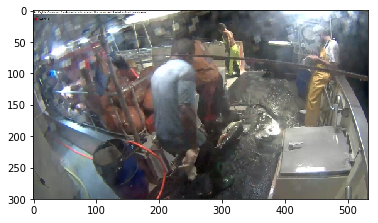

In [18]:
path = PATH/"train/ALB/img_02140.jpg"
im = resize_images(path)
plt.imshow(im)

In [156]:
train_path = PATH/"train-300"
valid_path = PATH/"valid-300"

train_path.mkdir(exist_ok=True)
valid_path.mkdir(exist_ok=True) 

In [30]:
def resize_all_images(train_path, valid_path, org_path, sz=300):
    np.random.seed(3)
    paths = [x for x in list(org_path.iterdir()) if x.is_dir()]
    for p in paths:
        label = p.parts[-1]
        (train_path/label).mkdir(exist_ok=True)
        (valid_path/label).mkdir(exist_ok=True) 
        files = list((org_path/label).iterdir())
        for f in files:
            f_name = f.parts[-1]
            if np.random.uniform() < 0.8:
                new_path = train_path/label/f_name
            else:
                new_path = valid_path/label/f_name
            im = resize_images(f)
            cv2.imwrite(str(new_path), cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

In [31]:
#run just the first time
resize_all_images(train_path, valid_path, PATH/"train")

In [32]:
# checking
for label in labels:
    all_files = len(list((PATH/"train"/label).iterdir()))
    train_files = len(list((train_path/label).iterdir()))
    valid_files = len(list((valid_path/label).iterdir()))
    print(label, all_files, train_files, valid_files)

ALB 1719 1377 342
BET 200 161 39
DOL 117 100 17
LAG 67 61 6
NoF 465 373 92
OTHER 299 233 66
SHARK 176 145 31
YFT 734 587 147


## Data augmentation
Data augmentation is the most important way to avoid overfitting for image classification tasks. For this problem we cannot crop much because we may leave the fish out.

In [24]:
# modified from fast.ai
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Resize, horizontal and vertical translations

(300, 533, 3)


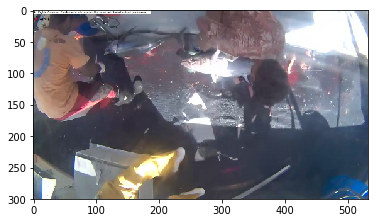

In [33]:
path = PATH/"train-300/ALB/img_03017.jpg"
im = read_image(path)
ratio = 1.778
sz1 = 280
sz2 = int(ratio*sz1)
im2 = random_crop(im, sz1, sz2)
plt.imshow(im)
print(im.shape)

(280, 497, 3)

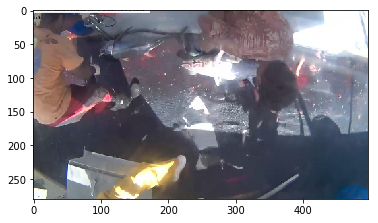

In [34]:
plt.imshow(im2)
im2.shape

### Random Rotation (-10, 10) 

-1.4853877976485785


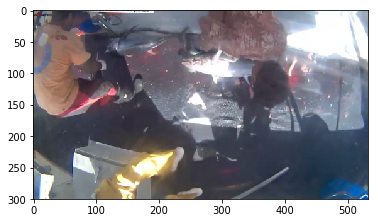

In [35]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot)

### Horizontal Flip

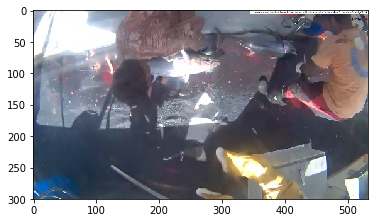

In [36]:
im_f = np.fliplr(im)
plt.imshow(im_f)

## Dataset

In [37]:
def resize_images_ratio(im, sz=300, r=1.778):
    sz2 = int(r*sz)
    return cv2.resize(im, (sz2, sz))

In [38]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [39]:
class FishDataset(Dataset):
    def __init__(self, PATH, train="train-300", transforms=False, sz=280):
        self.path_to_images = PATH/train
        self.transforms = transforms
        self.sz = sz
        self.sz2 = int(self.sz*1.778)
        self.paths = sorted([x for x in list(self.path_to_images.iterdir()) if x.is_dir()])
        self.files = [f for d in self.paths for f in list(d.iterdir())]
        self.labels = [p.parts[-1] for p in paths]
        self.label2ind = {v:k for k,v in enumerate(self.labels)}
        self.len = len(self.files)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        path = self.files[idx] 
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        # center crop
        if self.transforms:
            # assumes original images are 300x533 otherwise resize here.
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
            x = random_crop(x, self.sz, self.sz2)
        else:
            x = resize_images_ratio(x, self.sz)
        # substract numbers from resnet34
        x = normalize(x)
        y = self.label2ind[path.parts[-2]]
        return np.rollaxis(x, 2), y

In [40]:
train_ds = FishDataset(PATH, "train-300", transforms=True)
valid_ds = FishDataset(PATH, "valid-300")

In [42]:
len(train_ds), len(valid_ds)

(3037, 740)

In [64]:
batch_size = 10
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [65]:
# run this multiple times to get different images
x, y = train_ds[0]
#plt.imshow(np.rollaxis(x1, 2), cmap='gray')

In [66]:
x.shape,y

((3, 280, 497), 0)

In [67]:
x,y = next(iter(valid_dl))
x.shape

torch.Size([10, 3, 280, 497])

In [68]:
x, y = valid_ds[0]
x.shape

(3, 280, 497)

## Model

In [69]:
resnet = models.resnet34(pretrained=True)
#resnet 

In [70]:
layers = list(resnet.children())
print(len(layers))
layers[-2:]

10


[AvgPool2d(kernel_size=7, stride=1, padding=0),
 Linear(in_features=512, out_features=1000, bias=True)]

In [82]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 8)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        #x = nn.Dropout(0.2)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        #x = nn.Dropout(0.2)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [83]:
model = Net().cuda()

In [101]:
x, y = next(iter(train_dl))
x.shape, y.shape

(torch.Size([10, 3, 280, 497]), torch.Size([10]))

In [102]:
x = x.cuda().float()
y = y.cuda()

In [103]:
x_features = model.top_model(x)
x_features.shape

torch.Size([10, 512, 9, 16])

In [104]:
# AdaptiveAvgPool2d would do a similar job if the input is [64, 512, 10, 20]
# that is why this model will fit any input size
x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features)
x_features_ave.shape

torch.Size([10, 512, 1, 1])

In [105]:
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

torch.Size([10, 512])

In [106]:
y_hat = model(x)
y_hat.shape

torch.Size([10, 8])

In [107]:
y.shape

torch.Size([10])

In [126]:
_, pred = torch.max(y_hat, 1)
pred

tensor([ 1,  7,  7,  4,  2,  6,  6,  6,  5,  1], device='cuda:0')

In [128]:
y

tensor([ 0,  7,  7,  0,  7,  0,  4,  0,  5,  5], device='cuda:0')

In [129]:
pred.eq(y).sum()

tensor(3, device='cuda:0')

In [109]:
# This loss combines a Sigmoid layer and the BCELoss in one single class. see
# https://pytorch.org/docs/master/nn.html#torch.nn.BCEWithLogitsLoss
F.cross_entropy(y_hat, y)

tensor(2.0209, device='cuda:0')

## Learning rate finder

In [110]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [116]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-6, lr_high=0.4, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x,y in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses 

In [121]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [122]:
model = Net().cuda()
lrs, losses = LR_range_finder(model, train_dl)

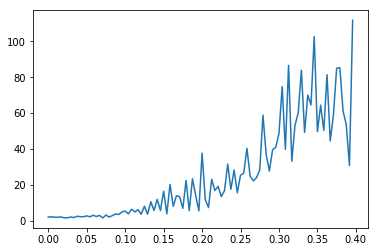

In [123]:
plt.plot(lrs, losses)
plt.show()

## Triangular learning rate training

In [119]:
def get_triangular_lr2(lr_low, lr_high, stepesize):
    iterations = 2*stepesize
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

In [124]:
def train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-5, lr_high=0.01):
    idx = 0
    epochs = 4
    stepesize = 2*len(train_dl)
    lrs = get_triangular_lr2(lr_low, lr_high, stepesize)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss", sum_loss/total)
        val_metrics(model, valid_dl)
    return sum_loss/total

In [135]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for i, (x, y) in enumerate(valid_dl):
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda()
        out = model(x)
        _, pred = torch.max(out, 1)
        correct += pred.eq(y).sum().item()
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    print("val loss and accuracy", sum_loss/total, correct/total)

## Training with triangular rates

In [131]:
from datetime import datetime

def training_loop(model, train_dl, valid_dl, steps=3, lr_low=1e-5, lr_high=0.01):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy(model, train_dl, valid_dl, lr_low, lr_high)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [132]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [133]:
model = Net().cuda()

In [136]:
val_metrics(model, valid_dl)

val loss and accuracy 2.0450939642416466 0.2918918918918919


In [137]:
training_loop(model, train_dl, valid_dl, steps=1)

train loss 1.287525011298293
val loss and accuracy 0.9136436520396052 0.7202702702702702
train loss 0.7011226004858648
val loss and accuracy 0.5705839469626143 0.8162162162162162
train loss 0.33472508336314644
val loss and accuracy 0.3366896194380683 0.8864864864864865
train loss 0.22496283150519986
val loss and accuracy 0.3224974480835167 0.8918918918918919
----End of step Time elapsed 0:03:33.698698


In [138]:
training_loop(model, train_dl, valid_dl, steps=1)

train loss 0.24318417957789182
val loss and accuracy 0.5651236350471909 0.845945945945946
train loss 0.375406174134533
val loss and accuracy 0.535833658237715 0.8418918918918918
train loss 0.19130356294330814
val loss and accuracy 0.25948940443026053 0.9094594594594595
train loss 0.12425598836049148
val loss and accuracy 0.24694359592489293 0.9243243243243243
----End of step Time elapsed 0:03:33.944709


In [139]:
training_loop(model, train_dl, valid_dl, steps=1)

train loss 0.14850010268775343
val loss and accuracy 0.27700598868163856 0.9108108108108108
train loss 0.2532705732050561
val loss and accuracy 0.3700144247026057 0.904054054054054
train loss 0.15247190519455903
val loss and accuracy 0.29118709084955424 0.9351351351351351
train loss 0.09744734952215854
val loss and accuracy 0.2818736388675264 0.9351351351351351
----End of step Time elapsed 0:03:29.814069


## Unfreezing layers

In [140]:
# save model
def save_model(m, p): 
    torch.save(m.state_dict(), p)
p = PATH/"model.pth"
save_model(model, p)

In [141]:
# load model
p = PATH/"model.pth"
model.load_state_dict(torch.load(p))

In [142]:
val_metrics(model, valid_dl)

val loss and accuracy 0.2818736388675264 0.9351351351351351


In [143]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [144]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [145]:
unfreeze(model, 7)
unfreeze(model, 6)

In [146]:
train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-6, lr_high=1e-4)

train loss 0.11424722470487855
val loss and accuracy 0.48907064701858405 0.9027027027027027
train loss 0.15251279041136728
val loss and accuracy 0.3068601521688539 0.9283783783783783
train loss 0.06471914569315233
val loss and accuracy 0.14524638395051698 0.9648648648648649
train loss 0.03162889964179377
val loss and accuracy 0.13871959866704167 0.9662162162162162


0.03162889964179377

In [147]:
train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-6, lr_high=1e-4)

train loss 0.032150891077437016
val loss and accuracy 0.2684073898437861 0.9391891891891891
train loss 0.06259658061775047
val loss and accuracy 0.27512442389050046 0.9283783783783783
train loss 0.03275712261544979
val loss and accuracy 0.12660439755465533 0.9635135135135136
train loss 0.017297849853964358
val loss and accuracy 0.1199247690471443 0.9716216216216216


0.017297849853964358

## Testing time augmentation
Testing time augmentation is a technique that uses data aumentation at test time to improve the test predictions.

In [149]:
valid_ds = FishDataset(PATH, "valid-300")
valid_ds_trs = FishDataset(PATH, "valid-300", transforms=True)

In [150]:
batch_size = 64
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
valid_dl_trs = DataLoader(valid_ds_trs, batch_size=batch_size)

In [151]:
def val_arrays(model, dl):
    model.eval()
    preds = []
    ys = []
    for x, y in dl:
        x = x.cuda().float()
        out = model(x)
        _, pred = torch.max(out, 1)
        preds.append(pred.cpu().numpy())
        ys.append(y.unsqueeze(1).numpy())
    return np.vstack(preds), np.vstack(ys)

In [152]:
preds, ys = val_arrays(model, valid_dl)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [ ]:
preds

In [ ]:
def TTAaccuracy(model, valid_dl, valid_dl_trs, ndls=4):
    preds, ys = val_arrays(model, valid_dl)
    pred_tuples = [val_arrays(model, valid_dl_trs) for i in range(ndls)]
    tr_preds = [p for p,y in pred_tuples]
    pp = np.hstack(tr_preds + [preds])
    final_prob = pp.mean(1)
    final_prediction = final_prob > 0.5
    return (final_prediction[:, None] == ys).sum()/len(final_prediction)

In [ ]:
TTAaccuracy(model, valid_dl, valid_dl_trs)

## Bounding boxes and multi-task learning
A kaggle user has created bounding boxes for each fish in the training set. [Here](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/discussion/25902) is a link to download them. We will use the bounding boxes by training a model to not only predict the class of the fish but also the bounding box.

In [171]:
import ujson as json
import requests

In [158]:
url_prefix = 'https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/'
annot_urls = {
        '5458/bet_labels.json': 'bd20591439b650f44b36b72a98d3ce27',
        '5459/shark_labels.json': '94b1b3110ca58ff4788fb659eda7da90',
        '5460/dol_labels.json': '91a25d29a29b7e8b8d7a8770355993de',
        '5461/yft_labels.json': '9ef63caad8f076457d48a21986d81ddc',
        '5462/alb_labels.json': '731c74d347748b5272042f0661dad37c',
        '5463/lag_labels.json': '92d75d9218c3333ac31d74125f2b380a'
    }

In [167]:
# download annotations
def download_annotations():
    anno_dir = PATH/"annotations"
    anno_dir.mkdir(exist_ok=True)
    for url_suffix in annot_urls:
        url = url_prefix + url_suffix
        r = requests.get(url, allow_redirects=True)
        json_file = url_suffix.split("/")[1]
        open(anno_dir/json_file, 'wb').write(r.content)
#download_annotations()

In [169]:
jfiles = list((PATH/"annotations").iterdir())
jfiles

[PosixPath('/data2/yinterian/fisheries/annotations/shark_labels.json'),
 PosixPath('/data2/yinterian/fisheries/annotations/yft_labels.json'),
 PosixPath('/data2/yinterian/fisheries/annotations/alb_labels.json'),
 PosixPath('/data2/yinterian/fisheries/annotations/lag_labels.json'),
 PosixPath('/data2/yinterian/fisheries/annotations/bet_labels.json'),
 PosixPath('/data2/yinterian/fisheries/annotations/dol_labels.json')]

In [172]:
bb_json = {}
jfiles = list((PATH/"annotations").iterdir())
for f in jfiles:
    j = json.load(open(f, 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]

In [173]:
bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

# References
This notebook is based on the Keras implementation from [fast.ai](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson7.ipynb).